In [1]:
import datetime
from math import sqrt

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from domus_analytica.config import DomusSettings
from domus_analytica.data_clean import extract_info_to_table

config = DomusSettings(_env_file=".env.local")

# Extract Data and Preprocessing 

In [2]:
def data_preprocessing(data: pd.DataFrame):
    # Data preprocessing
    data["unit_price"] = data["price"] / data["exclusive_area"]
    data["completion_date_number"] = (
            pd.to_datetime(data["completion_date"]).astype(int)
            / (10 ** 9 * (24 * 60 * 60) * 365.25)
            + 1970
    )
    data["min_distance_to_busy_area"] = data[
        ["distance_to_hakata",
         "distance_to_ohori_park",
         "distance_to_tenjin"]
    ].min(axis=1)
    data["floor_ratio"] = data["floor"] * 1.0 / data["total_floors"]

    def direction_mapping(s: str) -> str:
        return s.replace("東", "E").replace("南", "S").replace("西", "W").replace("北", "N")

    data["direction"] = data["direction"].map(direction_mapping)

    data = pd.get_dummies(data, columns=["direction"], dtype="float32")
    data = pd.get_dummies(data, columns=["layout_main"], dtype="float32")
    data = pd.get_dummies(data, columns=["build_type"], dtype="float32")

    return data


df = data_preprocessing(
    extract_info_to_table(
        config,
        {'search_time': datetime.datetime(2024, 4, 1, 14, 46, 31, 449000)}
    )
)
df.head().transpose()

,0,1,2,3,4
id,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7437...,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7460...,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7250...,/ms/chuko/fukuoka/sc_fukuokashiminami/nc_73552...,/ms/chuko/fukuoka/sc_fukuokashihakata/nc_74582...
name,モントーレブルー・ラ・メール Fukuoka,ファーネスト箱崎公園,Asobi+ JGMヴェルデ香椎南弐番館,エイルヴィラクレアテュール井尻南II,アンピール吉塚
address,福岡県福岡市東区西戸崎２-1-30,福岡県福岡市東区松田２,福岡県福岡市東区八田１,福岡県福岡市南区曰佐２,福岡県福岡市博多区吉塚６
lat,33.6461037815746,33.6203572036973,33.63406257298,33.540890670713,33.6075918806721
lon,130.3599501447,130.443550474538,130.456704058744,130.438664435095,130.429482478425
price,2080.0,2080.0,2490.0,2580.0,2780.0
exclusive_area,57.25,69.85,93.33,75.42,65.1
common_area,11.04,38.1,24.55,20.88,14.0
completion_date,2007-01-01,2008-06-01,2001-06-01,1999-05-01,2000-11-01
layout_storage_room,0,0,0,0,0


# Train XGB model to predict unit price

In [3]:
from itertools import chain

import pandas as pd
from xgboost import XGBRegressor

feature_prefixes = ["direction_", "layout_main_", "build_type_"]
features = list(set(chain(
    [
        "min_distance_to_busy_area",
        "distance_to_nearest_station",
        "distance_to_hakata",
        "distance_to_ohori_park",
        "distance_to_tenjin",
        "min_distance_to_mafia",
        "min_distance_to_cemetery",
    ],
    [
        "bus_station_count",
        "restaurant_count",
        "supermarket_count",
        "convenience_store_count",
        "drugstore_count",
        "park_count",
        "cafe_count",
        "floor",
        "total_floors",
        "floor_ratio",
        "common_area",
        "layout_storage_room",
        "exclusive_area",
        "completion_date_number",
        "monthly_fee_total",
    ],
    *(
        [col for col in df.columns if col.startswith(feature_prefix)]
        for feature_prefix in feature_prefixes
    )
)))
target = "unit_price"

print("Using features: {} to predict {}".format(",".join(features), target))

test_ratio = 0.1
val_ratio = 0.1
random_state = 123
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=test_ratio, random_state=random_state
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(val_ratio / (1 - test_ratio)), random_state=random_state
)

model = XGBRegressor(n_estimators=6, max_depth=7, objective="reg:squarederror", eval_metric="rmse")
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
print(
    f"R-Square: Train={model.score(X_train, y_train)}, test={model.score(X_test, y_test)}"
)
print(
    f"単価のRMSE (万円): Train={sqrt(mean_squared_error(model.predict(X_train), y_train))}, test={sqrt(mean_squared_error(model.predict(X_test), y_test))}"
)

total_rmse_train = sqrt(
    mean_squared_error(
        model.predict(X_train) * X_train["exclusive_area"],
        y_train * X_train["exclusive_area"],
    )
)
total_rmse_test = sqrt(
    mean_squared_error(
        model.predict(X_test) * X_test["exclusive_area"],
        y_test * X_test["exclusive_area"],
    )
)
print(f"総金額のRMSE (万円): Train={total_rmse_train}, test={total_rmse_test}")
df["unit_price_estimate"] = model.predict(df[features])
df["price_estimate"] = df["unit_price_estimate"] * df["exclusive_area"]

Using features: layout_storage_room,direction_W,min_distance_to_busy_area,supermarket_count,distance_to_nearest_station,completion_date_number,common_area,distance_to_tenjin,restaurant_count,direction_E,direction_S,layout_main_2DK,layout_main_3LK,direction_NW,layout_main_4LDK,distance_to_ohori_park,build_type_RC,floor_ratio,drugstore_count,distance_to_hakata,build_type_wood,layout_main_2LDK,monthly_fee_total,build_type_unknown,direction_SE,convenience_store_count,direction_NE,bus_station_count,min_distance_to_cemetery,floor,direction_N,total_floors,cafe_count,min_distance_to_mafia,exclusive_area,layout_main_3LDK,direction_SW,park_count to predict unit_price
[0]	validation_0-rmse:13.35277
[1]	validation_0-rmse:11.37112
[2]	validation_0-rmse:10.23139
[3]	validation_0-rmse:9.33776
[4]	validation_0-rmse:8.63515
[5]	validation_0-rmse:8.31856
R-Square: Train=0.9508692895205627, test=0.8195241634886234
単価のRMSE (万円): Train=3.7885573811579762, test=6.604261691333414
総金額のRMSE (万円): Train=303.847

In [4]:
pd.DataFrame(
    zip(features, model.feature_importances_),
    columns=["features", "importances"],
).sort_values(by="importances", ascending=False)

,features,importances
15,distance_to_ohori_park,0.186727
2,min_distance_to_busy_area,0.173499
5,completion_date_number,0.146025
32,cafe_count,0.093832
33,min_distance_to_mafia,0.060111
37,park_count,0.055293
16,build_type_RC,0.035503
21,layout_main_2LDK,0.028057
34,exclusive_area,0.022791
18,drugstore_count,0.022387


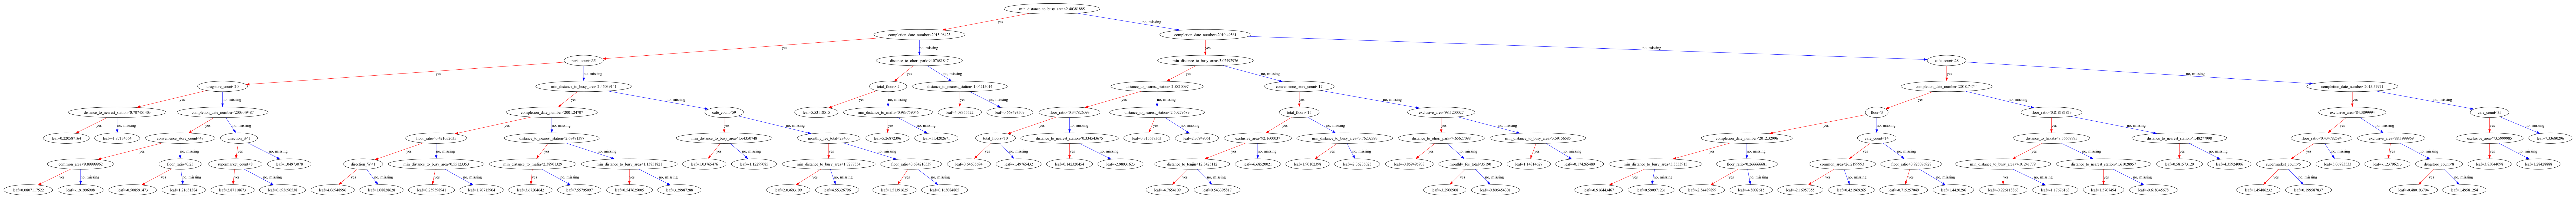

In [5]:
from xgboost import plot_tree
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [128, 32]
plot_tree(model)
plt.savefig("output/xgboost_model.png")

# Error Analysis

## Error Visualization for unit price

Mu=0.14217649377513436 Std=4.772402296913419


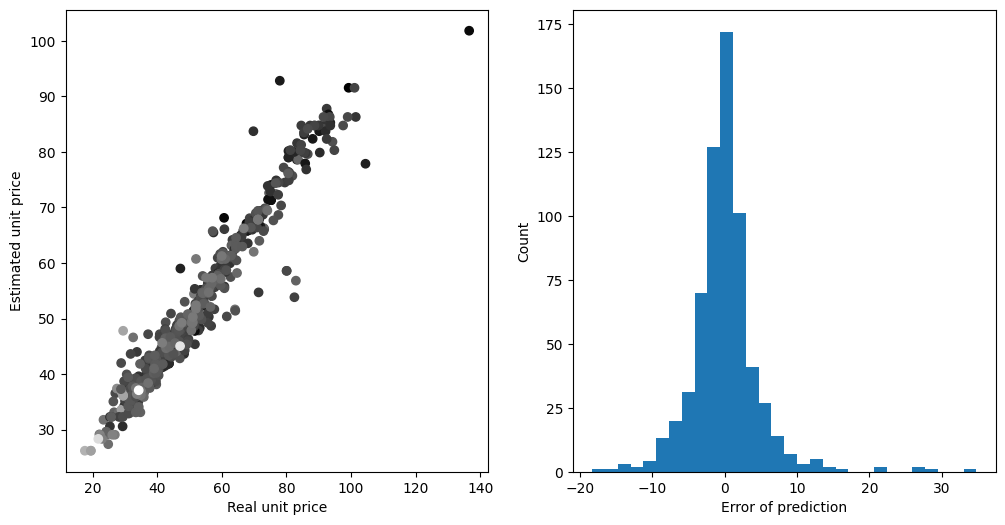

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6))
[ax1, ax2] = fig.subplots(1, 2)
_ = ax1.scatter(df["unit_price"], df["unit_price_estimate"], c=df["exclusive_area"], cmap="gray")
ax1.set_xlabel("Real unit price")
ax1.set_ylabel("Estimated unit price")
unit_price_error = df["unit_price"] - df["unit_price_estimate"]
_ = ax2.hist(unit_price_error, bins=30)
ax2.set_xlabel("Error of prediction")
ax2.set_ylabel("Count")
print(f"Mu={unit_price_error.to_numpy().mean()} Std={unit_price_error.to_numpy().std()}")

## Error Analysis for Total Price

Mu=-4.287130895576511 Std=389.6399372905154


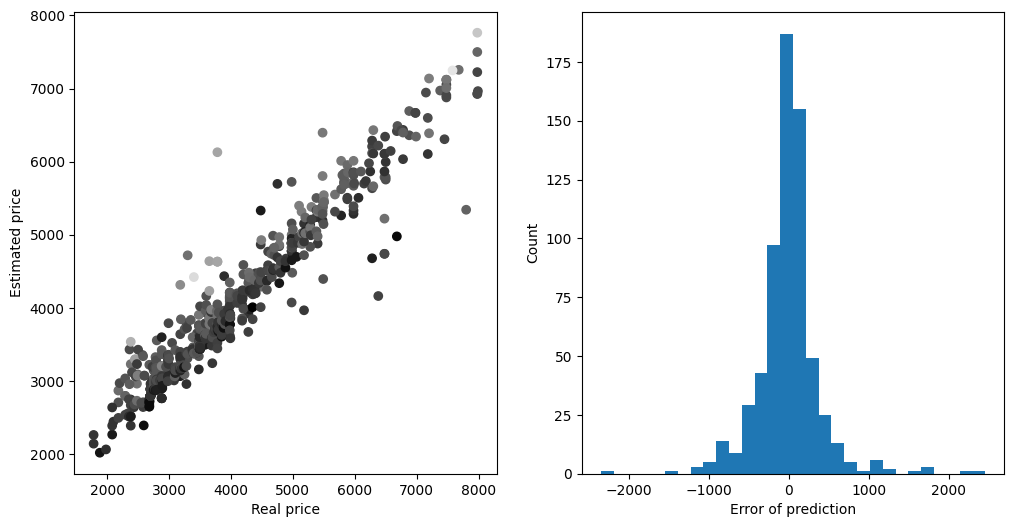

In [7]:
fig = plt.figure(figsize=(12, 6))
[ax1, ax2] = fig.subplots(1, 2)
_ = ax1.scatter(df["price"], df["price_estimate"], c=df["exclusive_area"], cmap="gray")
ax1.set_xlabel("Real price")
ax1.set_ylabel("Estimated price")
price_error = df["price"] - df["price_estimate"]
_ = ax2.hist(price_error, bins=30)
ax2.set_xlabel("Error of prediction")
ax2.set_ylabel("Count")
print(f"Mu={price_error.to_numpy().mean()} Std={price_error.to_numpy().std()}")

## Distribution for CP value

CP value is the ration between estimated price and real price.
It assumes that the model's predictions are fundamentally accurate, and that the prediction errors come from different sellers' psychological expectations.

When we have a model that also works well on the test set, we can use CP Value to estimate the profit margin.

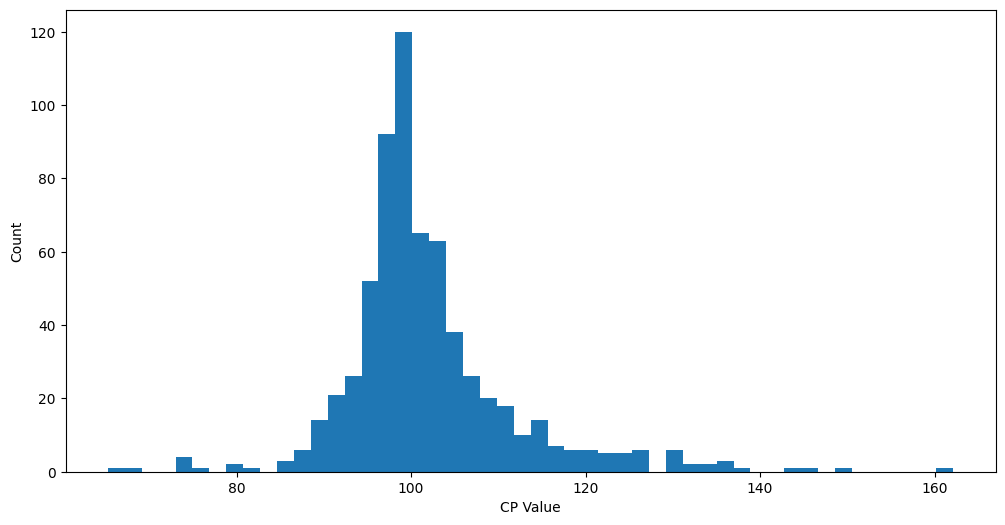

In [8]:
plt.rcParams['figure.figsize'] = [12, 6]
df["cp_value"] = df["price_estimate"] * 100.0 / df["price"]
plt.hist(df["cp_value"], bins=50)
plt.xlabel("CP Value")
_ = plt.ylabel("Count")

# Save The Result

Save the result to CSV file and order by CP value desc.

In [9]:
df.sort_values(by=["cp_value"], ascending=False).to_csv("data/result-xgb.csv", index=False)